# Lesson 5: Exercises

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Exercise 1: Combine nonbinding tracer with binding components

From the tutorial, combine the dextran pulse with the langmuir experiment.
Then, start modifying:
- Feed concentrations
- Adsorption parameters
- Transport parameters
- Flow Rates

Simulation completed successfully


Text(0, 0.5, '$concentration~/~mol \\cdot L^{-1} $')

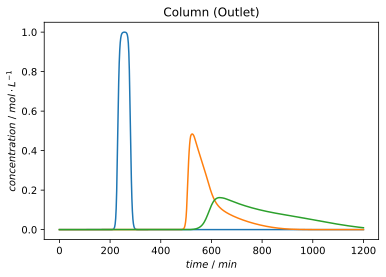

In [2]:
combined_model = get_cadet_template(n_units=3)

n_comp = 3

# INLET
combined_model.root.input.model.unit_000.unit_type = 'INLET'
combined_model.root.input.model.unit_000.ncomp = n_comp
combined_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# Column
combined_model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'
combined_model.root.input.model.unit_001.ncomp = n_comp

combined_model.root.input.model.unit_001.col_length = 0.6
combined_model.root.input.model.unit_001.cross_section_area = 1.0386890710931253E-4
combined_model.root.input.model.unit_001.col_porosity = 0.37
combined_model.root.input.model.unit_001.par_porosity = 0.33
combined_model.root.input.model.unit_001.par_radius = 4.5e-5
combined_model.root.input.model.unit_001.col_dispersion = 1.0e-7
combined_model.root.input.model.unit_001.film_diffusion = [0, 1e-4, 1e-4]

combined_model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

combined_model.root.input.model.unit_001.adsorption.is_kinetic = True
combined_model.root.input.model.unit_001.adsorption.mcl_ka = [0, 2, 3]
combined_model.root.input.model.unit_001.adsorption.mcl_kd = [1, 1, 1]
combined_model.root.input.model.unit_001.adsorption.mcl_qmax = [1, 1, 1]

combined_model.root.input.model.unit_001.init_c = [0.0, 0.0, 0.0]
combined_model.root.input.model.unit_001.init_q = [0.0, 0.0, 0.0]

set_discretization(combined_model, n_col=100, n_bound=[1,1,1])

## OUTLET
combined_model.root.input.model.unit_002.ncomp = n_comp
combined_model.root.input.model.unit_002.unit_type = 'OUTLET'

# Sections and connections
combined_model.root.input.solver.sections.nsec = 2
combined_model.root.input.solver.sections.section_times = [0.0, 50.0, 1200.0]
combined_model.root.input.solver.sections.section_continuity = [0, 0]

## Inlet Profile
combined_model.root.input.model.unit_000.sec_000.const_coeff = [1.0, 1.0, 1.0]
combined_model.root.input.model.unit_000.sec_001.const_coeff = [0.0, 0.0, 0.0]

## Switches
combined_model.root.input.model.connections.nswitches = 1
combined_model.root.input.model.connections.switch_000.section = 0
combined_model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1e-7,
    1, 2, -1, -1, 1e-7
]

#set the times that the simulator writes out data for
combined_model.root.input.solver.user_solution_times = np.linspace(0, 1200, 601)

run_simulation(combined_model)

time = combined_model.root.output.solution.solution_times
c = combined_model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')

## Exercise 2: Multiple injections

For some processes, multiple injections onto a column in sequence.
Take the previous example and create an inlet profile with three injections. 
Try finding the best interval (cycle time) s.t. the column is used most efficiently.

***Hint:*** It might be advantageous to create a loop that handles the section times and inlet profiles.
Also strings can be modified in loops.
For example, the following snippet would create 'unit_000', 'unit_001', and 'unit_002'.
```Python3
for i in range(3):
    'unit_{0:03}'.format(i)
```

In [3]:
langmuir_model = get_cadet_template(n_units=3)

n_comp = 2 
n_injections = 3
t_inj = 30
t_cycle = 100

# INLET
langmuir_model.root.input.model.unit_000.unit_type = 'INLET'
langmuir_model.root.input.model.unit_000.ncomp = n_comp
langmuir_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# Column
langmuir_model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
langmuir_model.root.input.model.unit_001.ncomp = n_comp

langmuir_model.root.input.model.unit_001.col_length = 0.6
langmuir_model.root.input.model.unit_001.cross_section_area = 1.0386890710931253E-4
langmuir_model.root.input.model.unit_001.total_porosity = 0.6
langmuir_model.root.input.model.unit_001.col_dispersion = 1.0e-8

langmuir_model.root.input.model.unit_001.init_c = n_comp*[0.0,]
langmuir_model.root.input.model.unit_001.init_q = n_comp*[0.0,]

langmuir_model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

langmuir_model.root.input.model.unit_001.adsorption.is_kinetic = False
langmuir_model.root.input.model.unit_001.adsorption.mcl_ka = [1, 2]
langmuir_model.root.input.model.unit_001.adsorption.mcl_kd = [1, 1]
langmuir_model.root.input.model.unit_001.adsorption.mcl_qmax = [1, 1]

set_discretization(langmuir_model, n_col=40, n_bound=[1,1])

## Outlet
langmuir_model.root.input.model.unit_002.ncomp = n_comp
langmuir_model.root.input.model.unit_002.unit_type = 'OUTLET'

# Sections and connections
langmuir_model.root.input.solver.sections.nsec = 2*n_injections

langmuir_model.root.input.solver.sections.section_times = [0]
for inj in range(n_injections):
    langmuir_model.root.input.solver.sections.section_times.append(inj*t_cycle+t_inj)
    langmuir_model.root.input.solver.sections.section_times.append((inj+1)*t_cycle)
langmuir_model.root.input.solver.sections.section_continuity = (n_injections*2 - 1)*[0]

## Inlet Profile
for inj in range(n_injections):
    langmuir_model.root.input.model.unit_000['sec_{0:03}'.format(inj*2)].const_coeff = [1.0, 1.0]
    langmuir_model.root.input.model.unit_000['sec_{0:03}'.format(inj*2+1)].const_coeff = [0.0, 0.0]

## Switches
langmuir_model.root.input.model.connections.nswitches = 1
langmuir_model.root.input.model.connections.switch_000.section = 0
langmuir_model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1e-6,
    1, 2, -1, -1, 1e-6
]

Simulation completed successfully


Text(0, 0.5, '$concentration~/~mM$')

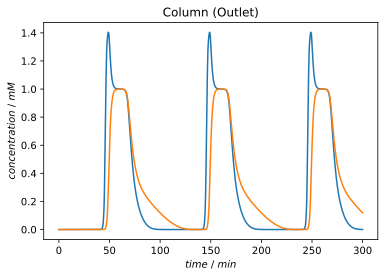

In [4]:
run_simulation(langmuir_model)

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

## Example 3: Load wash elute with three components

Add a second protein component to the LWE example from the tutorial lesson.
Assume that all parameters are the same as the first protein, only $k_a = 0.3~m^{3}_{MP}m^{-3}_{SP}s^{-1}$, and $\nu = 5.0$


Simulation completed successfully


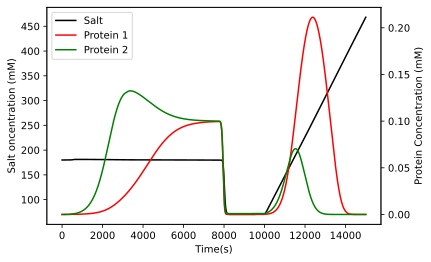

In [5]:
wash_start = 7500.0
grad_start = 9500.0
t_cycle = 15000.0

lwe_model = get_cadet_template(n_units=3)

# Sections and Switches
lwe_model.root.input.solver.sections.nsec = 3
lwe_model.root.input.solver.sections.section_times = [0.0, wash_start, grad_start, t_cycle]

lwe_model.root.input.model.unit_000.sec_000.const_coeff = [180.0, 0.1, 0.1]
lwe_model.root.input.model.unit_000.sec_001.const_coeff = [70.0, 0.0, 0.0]
lwe_model.root.input.model.unit_000.sec_002.const_coeff = [70.0, 0.0, 0.0]
lwe_model.root.input.model.unit_000.sec_002.lin_coeff = [0.08, 0.0, 0.0]

# set the times that the simulator writes out data for
lwe_model.root.input.solver.user_solution_times = np.linspace(0, t_cycle, int(t_cycle) + 1)


# System of Unit Operations
n_comp = 3

## INLET
lwe_model.root.input.model.unit_000.unit_type = 'INLET'
lwe_model.root.input.model.unit_000.ncomp = n_comp
lwe_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# GENERAL_RATE_MODEL
lwe_model.root.input.model.unit_001.unit_type = 'GENERAL_RATE_MODEL'
lwe_model.root.input.model.unit_001.ncomp = n_comp

lwe_model.root.input.model.unit_001.col_length = 0.25
lwe_model.root.input.model.unit_001.cross_section_area = 1.0386890710931253E-4
lwe_model.root.input.model.unit_001.col_porosity = 0.37
lwe_model.root.input.model.unit_001.par_porosity = 0.33
lwe_model.root.input.model.unit_001.par_radius = 4.5e-5
lwe_model.root.input.model.unit_001.col_dispersion = 2.0e-7

lwe_model.root.input.model.unit_001.film_diffusion = [2.0E-5, 2.0E-7, 2.0E-7]
lwe_model.root.input.model.unit_001.par_diffusion = [7e-5, 1e-9, 1e-9]
lwe_model.root.input.model.unit_001.par_surfdiffusion = [0.0, 0.0, 0.0]

## OUTLET
lwe_model.root.input.model.unit_002.unit_type = 'OUTLET'
lwe_model.root.input.model.unit_002.ncomp = n_comp

## Discretization
set_discretization(lwe_model, n_bound=[1,1,1])

# Connections
lwe_model.root.input.model.connections.nswitches = 1
lwe_model.root.input.model.connections.switch_000.section = 0
lwe_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, 2.88e-8,
                                                                1, 2, -1, -1, 2.88e-8]

sma_refc0 = lwe_model.root.input.model.unit_000.sec_002.lin_coeff[0] * (t_cycle - grad_start)
lambda_ = 225.0

lwe_model.root.input.model.unit_001.adsorption_model = 'STERIC_MASS_ACTION'
lwe_model.root.input.model.unit_001.adsorption.is_kinetic = 1
lwe_model.root.input.model.unit_001.adsorption.sma_ka = [0.0, 0.3, 0.2]
lwe_model.root.input.model.unit_001.adsorption.sma_kd = [0.0, 1.5, 1.5]
lwe_model.root.input.model.unit_001.adsorption.sma_lambda = lambda_
lwe_model.root.input.model.unit_001.adsorption.sma_nu = [0.0, 7.0, 5.0]
lwe_model.root.input.model.unit_001.adsorption.sma_refc0 = sma_refc0
lwe_model.root.input.model.unit_001.adsorption.sma_refq = lambda_
lwe_model.root.input.model.unit_001.adsorption.sma_sigma = [0.0, 50.0, 50.0]

lwe_model.root.input.model.unit_001.init_c = [180, 0.0, 0.0]
lwe_model.root.input.model.unit_001.init_q = [lambda_, 0.0, 0.0]

run_simulation(lwe_model)

#plot the simulation
fig, ax1 = plt.subplots()

ax1.plot(lwe_model.root.output.solution.solution_times,
    lwe_model.root.output.solution.unit_002.solution_outlet[:,0], 'k', label='Salt')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Salt oncentration (mM)')

ax2 = ax1.twinx()

ax2.plot(lwe_model.root.output.solution.solution_times,
    lwe_model.root.output.solution.unit_002.solution_outlet[:,1], 'r', label='Protein 1')
ax2.plot(lwe_model.root.output.solution.solution_times,
    lwe_model.root.output.solution.unit_002.solution_outlet[:,2], 'g', label='Protein 2')
ax2.set_ylabel('Protein Concentration (mM)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)